# Coursework 2: probabilistic ranking
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/cw/coursework2.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/). This version adapted by Damon Wischik._

In this assignment, you'll be using the (binary) results of the 2011 ATP men's tennis singles for 107 players in a total of 1801 games (which these players played against each other in the 2011 season), to compute probabilistic rankings of the skills of these players.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. Complete listings are
unnecessary. The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two.

In [1]:
import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
import scipy.io, scipy.stats, scipy.linalg
from numpy.linalg import solve
import requests, io
%matplotlib inline

## Data import

The match data is provided as `http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/tennis_data.mat`. It contains 
a vector $W$ of length 107 whose $i$th entry is the name of player $i$; and 
an array $G$ of dimension $1801\times2$, one row per game, where the first column contains the identity of 
the player who won and the second column contains the identify of the player who lost. Note that this convention means that the variable $y_g$ (the game outcome) in lecture notes is always $+1$, and can consequently be ignored. Some rows will appear more than once (corresponding to two players having played each other several times with the same outcome).

In [2]:
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1920/cw/tennis_data.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    W = np.concatenate(data['W'].squeeze())
    G = data['G'] - 1   # W[G[i,0]] is winner of game i, W[G[i,1]] is loser
    M = W.shape[0]      # number of players M = 107
    N = G.shape[0]      # number of games N = 1801
    max_player = 106

The appendix at the bottom of this document shows a crude ranking of the players, based on the fraction of their games that they win.

## Question (a)

Complete the following code for Gibbs sampling, by adding the lines required to sample from the conditional distributions needed for Gibbs sampling for the ranking model discussed in lectures. Run the Gibbs sampler, e.g. for 1100 iterations. Plot some of the sampled player skills as a function of the Gibbs iteration (see the [appendix](#Appendix) for some tips on multiple plotting).

Does it look as though the Gibbs sampler is able to move around the posterior distribution? What are the burn-in and mixing times for the Gibbs sampler? It may be helpful to look at autocorrelation plots; see the [appendix](#Appendix).

In [3]:
def δ(x):
    return 1 if x == 0 else 0

In [4]:
pv = 0.5 * np.ones(M)   # prior variance

print(G.shape)
I = [G[g, 0] for g in range(G.shape[0])]
J = [G[g, 1] for g in range(G.shape[0])]

Σinv = np.zeros((M,M))
    
left  = G[:,0]
right = G[:,1]

for i in range(M):
    for j in range(i, M):
        if i == j:
            Σinv[i, j] = sum(left==i) + sum(right==j)
        else:
            Σinv[i, j] = -sum(np.logical_or(
                np.logical_and(G[:,0]==i, G[:,1]==j),
                np.logical_and(G[:,0]==j, G[:,1]==i)
            ))
            Σinv[j, i] = Σinv[i, j]

print('done')

(1801, 2)
done


In [5]:
Σinv_ = Σinv + np.eye(M)
Σ = np.linalg.inv(Σinv_)
ws = list()
w = np.zeros(M)         # skills, initialized to be the prior mean μ0 = 0
count = 0
for _ in range(1100): #1100
    # Sample performance differences (t) given skills (w) and outcomes (G)
    s = w[G[:,0]] - w[G[:,1]]
    σ = 1
    t = s + σ * scipy.stats.norm.ppf(1 - np.random.uniform(size=N)*(1-scipy.stats.norm.cdf(-s/σ)))

    # Sample skills given performance differences
    μtilde = np.zeros(M)
    for i in range(M):
        #sum([t[g]*(δ(i-I[g])-δ(i-J[g])) for g in range(N)])
        μtilde[i] = np.dot(t, (1*(G[:,0]==i)-1*(G[:,1]==i)))
        
    μtilde = np.array(μtilde)
    μ = Σ @ μtilde
    w = np.random.multivariate_normal(mean=μ, cov=Σ)
    count+=1
    if (count % 1) == 0:
        ws.append(w)

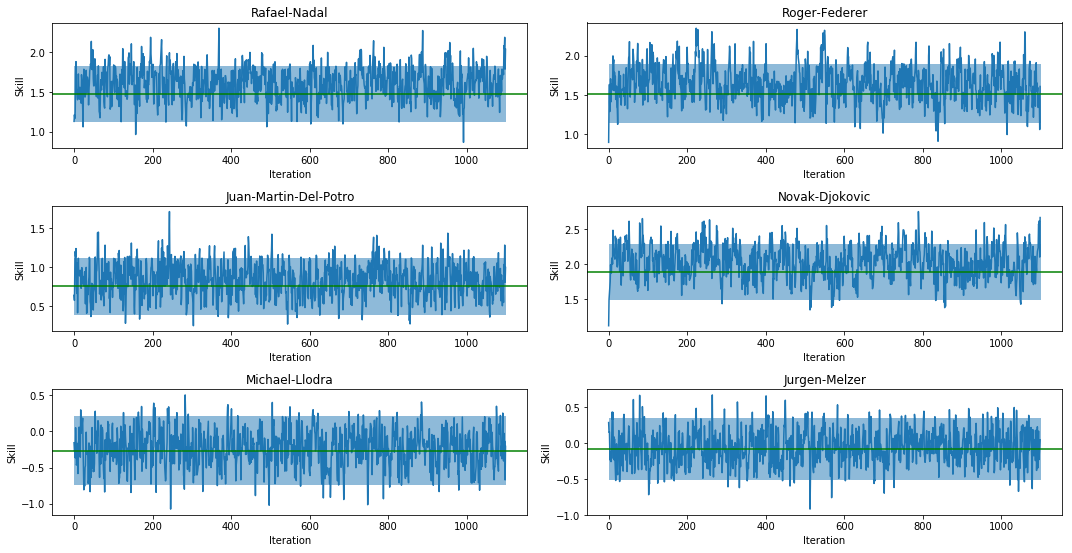

In [26]:
plt.figure(figsize=(15,15))
i = 1
players = [0, 4, 2, 15, 27, 76]

ws_ = np.array(ws)

for player in players:
    plt.subplot(len(players), 2, i)
    i+=1
    plt.plot(ws_[:,player])
    plt.xlabel('Iteration')
    plt.ylabel('Skill')
    plt.title(W[player])
    plt.fill_betweenx([μs[:, player][-1] - 2*σs[:, player][-1], μs[:,player][-1] + 2*σs[:,player][-1]], [0], [1100], alpha=0.5)
    plt.axhline(y=μs[:,player][-1], xmin=0, xmax=1100, color='g')

    
    #plt.subplot(len(players), 2, i)
    #plt.acorr(ws_[:,player] - np.mean(ws_[:,player]), maxlags=40)
    #plt.xlim(-1,40)
    plt.tight_layout()

    

Looking at the autocorrelation plots, after approximately 4 lags, the samples are uncorrelated, meaning the Gibbs sampler is exploring the posterior.

From the skill vs. iteration plots, the distribution seems to settle after approximately 40 iterations. This suggests a safe burn-in of 40 iterations.

## Question (b)

Do inference in the model instead, by running message passing and expectation propagation, using the code below. For the same players you plotted in part (a), show the mean and standard deviation of their skill levels as a function of the iteration. How long does it take to converge?

(See the Python programming note in the appendix, about the `yield` statement and how to use `gaussian_ep`.)

In [7]:
def gaussian_ep(G, M):
    def Ψ(x): return scipy.stats.norm.pdf(x) / scipy.stats.norm.cdf(x)
    def Λ(x): return Ψ(x) * (Ψ(x) + x)
    N = len(G)

    μ_s, p_s = np.empty(M)+5, np.empty(M)
    μ_gs, p_gs = np.zeros((N,2)), np.zeros((N,2))
    μ_sg, p_sg = np.empty((N,2)), np.empty((N,2))
    
    while True:
        # 1. Compute marginal skills
        # Let skills be N(μ_s, 1/p_s)
        p_s = np.ones(M) * 1/0.5
        μ_s = np.zeros(M)
        for j,(winner,loser) in enumerate(G):
            p_s[winner] += p_gs[j,0]
            p_s[loser] += p_gs[j,1]
            μ_s[winner] += μ_gs[j,0] * p_gs[j,0]
            μ_s[loser] += μ_gs[j,1] * p_gs[j,1]
        μ_s = μ_s / p_s

        # 2. Compute skill -> game messages
        # winner's skill -> game: N(μ_sg[,0], 1/p_sg[,0])
        # loser's skill -> game: N(μ_sg[,1], 1/p_sg[,1])
        p_sg = p_s[G] - p_gs
        μ_sg = (p_s[G]*μ_s[G] - p_gs*μ_gs) / p_sg

        # 3. Compute game -> performance messages
        v_gt = 1 + np.sum(1/p_sg, 1)
        σ_gt = np.sqrt(v_gt)
        μ_gt = μ_sg[:,0] - μ_sg[:,1]

        # 4. Approximate the marginal on performance differences
        μ_t = μ_gt + σ_gt * Ψ(μ_gt/σ_gt)
        p_t = 1 / v_gt / (1-Λ(μ_gt/σ_gt))

        # 5. Compute performance -> game messages
        p_tg = p_t - 1/v_gt
        μ_tg = (μ_t*p_t - μ_gt/v_gt) / p_tg

        # 6. Compute game -> skills messages
        # game -> winner's skill: N(μ_gs[,0], 1/p_gs[,0])
        # game -> loser's skill: N(μ_gs[,1], 1/p_gs[,1])
        p_gs[:,0] = 1 / (1 + 1/p_tg + 1/p_sg[:,1])  # winners
        p_gs[:,1] = 1 / (1 + 1/p_tg + 1/p_sg[:,0])  # losers
        μ_gs[:,0] = μ_sg[:,1] + μ_tg
        μ_gs[:,1] = μ_sg[:,0] - μ_tg
        
        yield (μ_s, np.sqrt(1/p_s))

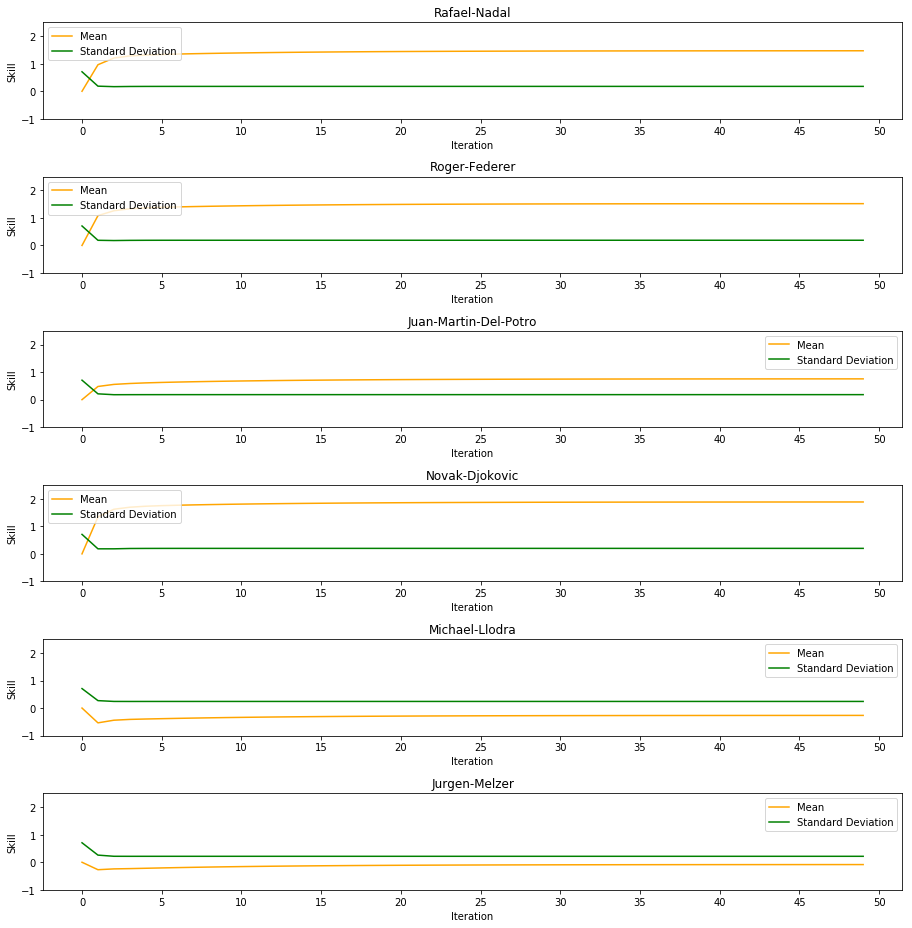

In [19]:
plt.figure(figsize=(13,13))
g = gaussian_ep(G, M)
i = 1; n = 50 # Iterations
μs = list(); σs = list()

for _ in range(n):
    μ, σ = next(g)
    μs.append(μ); σs.append(σ)
    
μs = np.array(μs); σs = np.array(σs)
for player in players:
    plt.subplot(len(players), 1, i)
    i+=1
    plt.plot(μs[:,player], color='orange', label='Mean')
    plt.plot(σs[:,player], color='green', label='Standard Deviation')
    plt.xlabel('Iteration')
    plt.ylabel('Skill')
    plt.legend()
    plt.title(W[player])
    plt.tight_layout()
    plt.ylim(-1,2.5)
    plt.xticks(np.arange(0, n+1, 5.0))

The message-propagation method converges after only a few iterations; the mean makes no noticeable deviation from iteration 4 or 5.

## Question (c)

Explain the concept of _convergence_ for both the Gibbs sampler and the message passing algorithms. What type of object are we converging to in the two cases, and how do you judge convergence? For each of the players you plotted in (a), find the mean and standard deviation of their skill as found by the converged algorithm in (b), and annotate the plot from part (a) to show those values. Explain what you see.

As a Markov chain Monte Carlo method, convergence for Gibb's sampling is when the equilibrium distribution of the Markov chain is the same as the desired distribution. This can be determined when the mean and standard deviation of the samples are not changing.

For message passing algorithms, convergence is when the change in the value of messages being propagated are not changing, or changing less than a small amount, i.e. $\epsilon$. This can also be determined when the mean and standard deviation of the samples are not changing.

## Question (d)

Who is better out of `W[0]` Rafael Nadal and `W[15]` Novak Djokovic? There are several ways we could answer this.

* Using the Gibbs sampler (and taking account of burn-in and mixing time), first compute the marginal distribution of skill for each of these players, then work out the probability that Nadal's skill is higher.
* Using the Gibbs sampler, use joint samples from the Gibbs sampler to directly estimate the probability.
* Using the message passing algorithm, read off the distribution of skills of these two players, and work out the probability that Nadal's skill is higher.
* Repeat these three methods, but this time to work out the probability that Nadal would beat Djokovic in a match.

Calculate all these six probabilities. Explain how they relate to each other. Which answer is best? Why? Support your explanation with appropriate plots.

Marginalisation involves simply ignoring the other players.

In [14]:
# Method 1: Gibbs sampler
print([1,2,3,4,5,6,7,8,9])
rafael = ws_[:, 0][50:][0::5] # burn-in and mixing
novak = ws_[:, 15][50:][0::5] # burn-in and mixing
μ_rafael = np.mean(rafael)
v_rafael = np.var(rafael)
μ_novak = np.mean(novak)
v_novak = np.var(novak)

μ_c = μ_rafael - μ_novak
v_c = v_rafael + v_novak

p = scipy.stats.norm.sf(0, loc=μ_c, scale=np.sqrt(v_c))
print(f"Probability of Nadal's skill > Djokovic's: {p*100:.2f}%")
p_win = scipy.stats.norm.cdf(μ_rafael-μ_novak, 0, 1)
print(f'Probability of Nadal beating Djokovic: {p_win*100:.2f}%')

[1, 3, 5, 7, 9]
Probability of Nadal's skill > Djokovic's: 8.87%
Probability of Nadal beating Djokovic: 33.84%


In [15]:
# Method 2: Gibbs joint
n = len(rafael)
p = sum(rafael > novak)/n
print(f"Probability of Nadal's skill > Djokovic's: {p*100:.2f}%")

samples = [np.random.normal(loc=rafael[i]-novak[i]) for i in range(n)]

p_win = np.sum(np.array(samples) > 0)/n
print(f'Probability of Nadal beating Djokovic: {p_win*100:.2f}%')

Probability of Nadal's skill > Djokovic's: 5.71%
Probability of Nadal beating Djokovic: 34.29%


In [16]:
# Method 3: message passing
μs = list()
σs = list()
for _ in range(20):
    μ, σ = next(g)
    μs.append(μ)
    σs.append(σ)
    
μ_rafael = μs[-1][0]
σ_rafael = σs[-1][0]
μ_novak = μs[-1][15]
σ_novak = σs[-1][15]

μ_c = μ_rafael - μ_novak
v_c = σ_rafael**2 + σ_novak**2
p = scipy.stats.norm.sf(0, loc=μ_c, scale=np.sqrt(v_c))
print(f"Probability of Nadal's skill > Djokovic's: {p*100:.2f}%")
p_win = scipy.stats.norm.cdf(μ_rafael-μ_novak, 0, 1)
print(f'Probability of Nadal beating Djokovic: {p_win*100:.2f}%')

Probability of Nadal's skill > Djokovic's: 6.02%
Probability of Nadal beating Djokovic: 33.95%


## Question (e)

Jarrett (Biometrika, 1979) compiled a dataset of the dates of coal mining explosions, from the _Colliery Year Book and Coal Trades Directory_. An initial plot suggests that there was a step change in the frequency of explosions, some time between 1880 and 1900. Consider the model
$$
\text{num.explosions in year }i \sim \operatorname{Poisson}(\lambda 1_{i\leq\theta} + \mu 1_{i>\theta})
$$
with prior distributions
$$
\lambda \sim \operatorname{Gamma}(a,b)\,,\quad
\mu \sim \operatorname{Gamma}(a,b)\,,\quad
\theta \sim \operatorname{Uniform}[1851,1852,\dots,1961]
$$
Use Gibbs sampling to estimate $\theta$. It's up to you to pick appropriate $a$ and $b$.

_This question asks you to invent a Gibbs sampler from scratch. This model is much simpler than the ranking model
studied in lectures. In your answer, you should explain how your Gibbs sampler works, but you shouldn't spend time worrying about burn-in and mixing time._

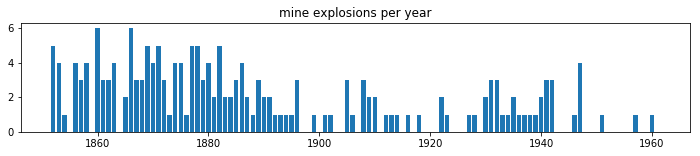

In [28]:
url = 'https://raw.githubusercontent.com/damonjw/probml/master/data/coal.txt'
coal = pandas.read_csv(url, names=['date'], parse_dates=['date'])

# Count number of explosions by year, and fill in missing years with count=0
counts = coal['date'].groupby(coal['date'].dt.year).apply(len)
y,Y = np.min(counts.index.values), np.max(counts.index.values)
df = pandas.DataFrame({'count': np.zeros(Y-y+1, dtype=int)}, index=np.arange(y,Y+1))
df.index.name = 'year'
df.loc[counts.index, 'count'] = counts
# Discard first and last year (for which counts might be incomplete)
df = df.reset_index()
df = df.loc[(df['year']>y) & (df['year']<Y)]

with matplotlib.rc_context({'figure.figsize': [12,2]}):
    plt.bar(df['year'].values, df['count'].values)
    plt.title('mine explosions per year')
plt.show()

In [40]:
x = df.iloc[:,1]; N = len(x)
a = np.mean(x)**2 / np.var(x)
b = np.var(x)/np.mean(x)

# Sample prior values 
theta = int(np.random.uniform()*N)
λ = np.random.gamma(a, 1/b)
μ = np.random.gamma(a, 1/b)
S = sum(x)
thetas = list()

# Precompute sums
sums = list()
for i in range(N): sums.append(sum(x[:i]))
    
for _ in range(500):
    # Sample λ, th, μ
    s_lower = sums[theta]
    λ  = np.random.gamma(a+s_lower, 1/(theta+b))
    μ  = np.random.gamma(a+S-s_lower, 1/(N-theta+b))
    ps = list()

    for th in range(N):
        s_lower = sums[th]
        ps.append(s_lower*np.log(λ) - th * λ + (S-s_lower)*np.log(μ)-(N-th)*μ)
    ps = np.exp(ps)
    ps = ps/sum(ps)

    # Sample theta
    theta = np.random.multinomial(1, ps, size=None).nonzero()[0][0]
    thetas.append(theta)

Mean value of theta: 39.196


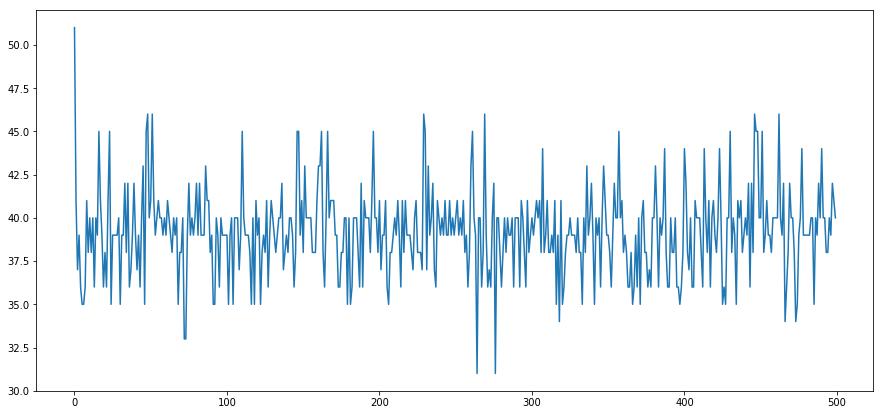

In [41]:
plt.figure(figsize=(15,7))
plt.plot(thetas)
print('Mean value of theta:', np.mean(thetas))

In [31]:
print('Year of step change:', df.iloc[:,0][39])

Year of step change: 1890


<div style="height: 20em"></div>

# Appendix

### Data import

Here is a crude ranking of the players, based on a simple ratio
$$
\frac{\text{number of wins for player }i}{\text{number of games played by player }i}.
$$

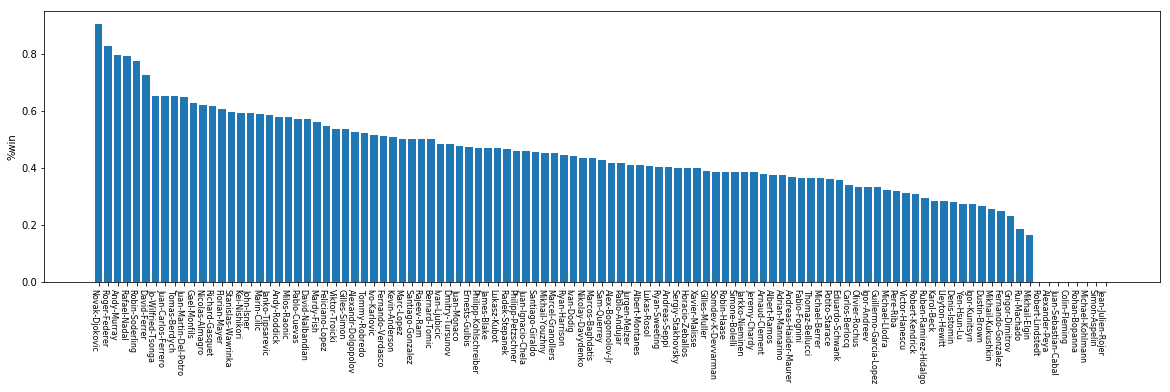

In [4]:
wins = np.zeros(M, dtype=int)
losses = np.zeros(M, dtype=int)
w, x = np.unique(G[:,0], return_counts=True)
wins[w] = x
w, x = np.unique(G[:,1], return_counts=True)
losses[w] = x
score = wins / (wins + losses)
rank_order = np.argsort(score)[::-1]

with matplotlib.rc_context({'figure.figsize': [20,5], 'xtick.labelsize': 8}):
    x = np.arange(M)
    plt.bar(x, score[rank_order], align='center', width=.8)
    plt.xticks(x, W[rank_order], rotation=-90, ha='right')
    plt.ylabel('%win')
plt.show()

### Question (a)

Some notes about the code in Question (a), and how it uses normally distributed random variables:

* If we just wanted to sample `t` given skill differences `s`, we could just use `t=np.random.normal(loc=s, scale=σ)`. But we actually want to generate `t` conditional on `t>0`. Using the [inversion transformation method](https://en.wikipedia.org/wiki/Inverse_transform_sampling) as mentioned in the notes, we end up with the code given here.
* We could also compute `μ` by defining `Rinv = scipy.linalg.cholesky(Σinv)` and then `μ=solve(Rinv, solve(Rinv.T, μtilde))`.
* We could also generate `w` by `w = μ + solve(Rinv, np.random.normal(size=M))`
* To generate a simple normal random variable with mean $\mu$ and variance $\sigma^2$, we can first generate $X\sim\operatorname{Normal}(0,1)$ and then return $\mu+\sigma X$. To generate a multivariate normal random variable with mean vector $\mu$ and covariance matrix $\Sigma$, we first generate $X\sim\operatorname{MVN}(0,I)$ and then return $\mu+R X$ where $R$ is the matrix square root of $\Sigma$. It can be found from the Cholesky decomposition $R R^\top=\Sigma$.

To plot many panels in a single figure,

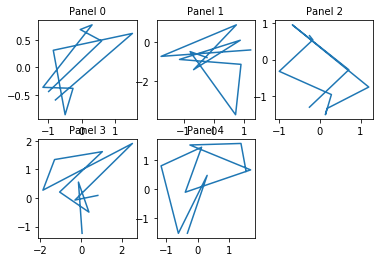

In [3]:
with matplotlib.rc_context({'figure.figsize': [6,4], 'axes.titlesize': 10}):
    fig = plt.figure()
    for i in range(5):
        ax = fig.add_subplot(2, 3, i+1)  # 2 rows of panels, 3 columns
        ax.plot(np.random.normal(size=10), np.random.normal(size=10))
        ax.set_title(f'Panel {i}')

c:\users\cobmo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


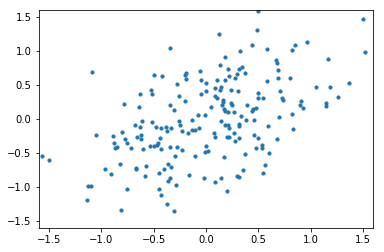

In [94]:
with matplotlib.rc_context({'figure.figsize': [6,4], 'axes.titlesize': 10}):
    fig = plt.figure()
    A = np.random.multivariate_normal([0,0], [[0.2,0.4],[0.4,0.2]], size=200)
    plt.scatter(A[:,0], A[:,1], s=10)
    plt.xlim([-1.6, 1.6])
    plt.ylim([-1.6, 1.6])
    plt.show()

To plot autocorrelations,

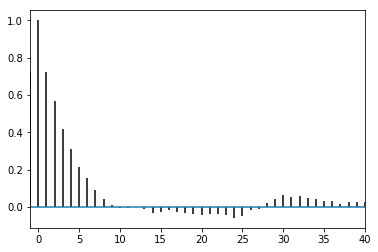

In [6]:
# Generate synthetic data with autocorrelations
x = [5, 5]
for _ in range(1000):
    lastx = x[-2:]
    nextx = np.mean(lastx) + 0.1 * np.random.normal() - 0.3 * (lastx[0] - 3)
    x.append(nextx)
x = np.array(x)
    
# Subtract the mean, then plot autocorrelation
plt.acorr(x - np.mean(x), maxlags=40)
plt.xlim(-1,40)
plt.show()

### Question (b)

The `gaussian_ep` function includes a `yield` statement, which means it is a lazy list generator, and you can use it with e.g.
```
g = gaussian_ep(G, M)
for _ in range(10):
    print(next(g))
```

### Question (d)

To evaluate $\mathbb{P}(\operatorname{Normal}(\mu,\sigma^2)>x)$, you can use the appropriate scientific function directly,
```
scipy.stats.norm.sf(x, loc=μ, scale=σ)
```
or you can compute it using Monte Carlo integration,
```
np.mean(np.random.normal(size=10000, loc=μ, scale=σ) > x)
```
For this simple calculation there's no point in Monte Carlo integration, but the technique
is useful in situations where there is no simple built-in scientific function.